In [136]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [137]:
# import r data
df_rfmt_full = pd.read_csv('datanew.csv')
df_rfmt_full.loc[(df_rfmt_full['Frequency'] == 0) & (df_rfmt_full['Recency'] == 0), 'Avg_Amount'] = 0
df_rfmt_full.head()

,Unnamed: 0,Customer_ID,Recency,Frequency,Count_of_transactions,Total_Amount,DPR,Age,Avg_Amount,CSI,months_inactive,CLV
0,1,12346,196,6,7,372.86,26,725,53.265714,1,0.204123,14.079332
1,2,12347,402,7,8,4921.53,126,404,615.191250,6,0.060640,287.393856
2,3,12348,363,4,5,1658.40,24,438,331.680000,5,0.268889,140.406568
3,4,12349,571,2,3,3678.69,137,589,1226.230000,5,0.111314,65.606970
4,5,12350,0,0,1,294.40,16,310,0.000000,2,0.000000,17.426721


In [138]:
print(type(df_rfmt_full))

<class 'pandas.core.frame.DataFrame'>


In [139]:
# select the relevant columns
df_rfmt = df_rfmt_full[['Customer_ID', 'Frequency', 'Recency', 'Age', 'Avg_Amount', 'CLV']]
df_rfmt.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,CLV
0,12346,6,196,725,53.265714,14.079332
1,12347,7,402,404,615.191250,287.393856
2,12348,4,363,438,331.680000,140.406568
3,12349,2,571,589,1226.230000,65.606970
4,12350,0,0,310,0.000000,17.426721


In [140]:
df_rfmt.shape

(5874, 6)

Basic BG/NBD/GG model

In [141]:
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(df_rfmt['Frequency'], df_rfmt['Recency'], df_rfmt['Age'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.662158,0.015824,0.631142,0.693173
alpha,63.263967,1.938250,59.464997,67.062936
a,0.109060,0.015559,0.078565,0.139555
b,2.453310,0.535146,1.404424,3.502197


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

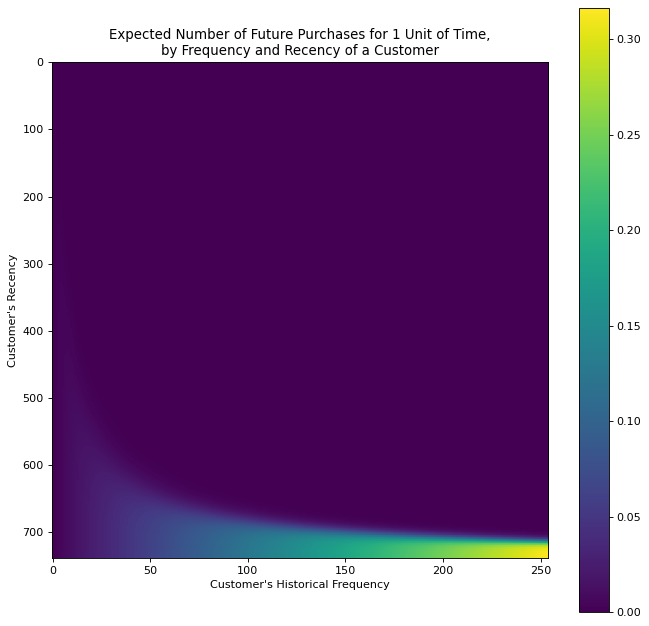

In [7]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plot_frequency_recency_matrix(bgf)

In [142]:
# Estimate the number of purchases a customer will make in the next 180 days
t = 180
df_rfmt['pred_purchases_180'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      df_rfmt['Frequency'], 
                                                                                      df_rfmt['Recency'], 
                                                                                      df_rfmt['Age'])

In [143]:
df_rfmt.sort_values(by='pred_purchases_180').tail(10)

,Customer_ID,Frequency,Recency,Age,Avg_Amount,CLV,pred_purchases_180
1432,13798,98,730,731,761.907778,4248.879906,22.078420
620,12971,98,721,724,158.632323,536.722457,22.264698
1788,14156,118,729,738,2569.799328,15328.797409,26.265102
2156,14527,120,735,737,225.180826,1419.270355,26.801500
737,13089,131,735,737,859.219015,12557.217592,29.246671
2235,14606,180,735,736,164.814199,961.447014,40.195852
5430,17841,192,736,737,355.156736,3469.396759,42.814170
2933,15311,195,738,738,586.563367,8402.806939,43.434158
399,12748,202,735,735,261.851034,2946.205464,45.156118
2537,14911,253,737,738,1134.041220,7328.269179,56.306828


In [144]:
df_rfmt.sort_values(by='pred_purchases_180').head(10)

,Customer_ID,Frequency,Recency,Age,Avg_Amount,CLV,pred_purchases_180
486,12835,36,309,736,162.076486,337.447593,1.913494e-09
5045,17448,17,148,645,806.870556,1039.394681,3.945038e-07
741,13093,42,460,735,1259.168605,1760.342867,5.666458e-05
1696,14063,6,45,731,1353.071429,406.126978,1.750202e-04
2219,14590,18,308,732,157.545789,188.333075,4.991638e-04
4361,16754,18,269,641,3447.372105,3695.422153,6.852320e-04
5438,17850,22,362,734,2226.472609,3029.948212,7.098310e-04
3253,15633,12,222,731,333.535385,84.745002,8.185821e-04
1792,14160,6,88,698,1203.067143,436.245095,2.245069e-03
5637,18051,6,96,730,326.040000,95.141519,2.309174e-03


In [ ]:
# this shows the model's predicted number of purchases each customer will make. To check that it makes sense, take a 
# customer say 620. The customer made 98 purchases in 721 days, that's 98/721 = 0.14 purchases per day, hence in 180 days
# will be around 25 purcahses. The model predicted 22 purchases which is very close to the customer's recorded daily 
# average rate. The slight disparity is due to the model's assumptions such as droupout rate.

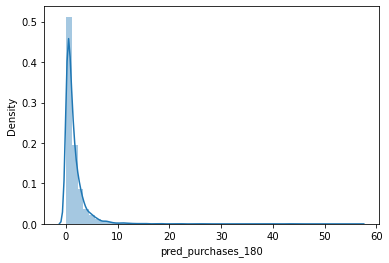

In [11]:
ax = sns.distplot(df_rfmt['pred_purchases_180'])

In [145]:
# add a column that calculates the predicted purchases throughout the lifetime
df_rfmt['Pred_purchases_lifetime'] = df_rfmt['pred_purchases_180']/180 * df_rfmt['Recency']
df_rfmt.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,CLV,pred_purchases_180,Pred_purchases_lifetime
0,12346,6,196,725,53.265714,14.079332,0.059895,0.065219
1,12347,7,402,404,615.191250,287.393856,2.863475,6.395094
2,12348,4,363,438,331.680000,140.406568,1.581371,3.189099
3,12349,2,571,589,1226.230000,65.606970,0.702552,2.228653
4,12350,0,0,310,0.000000,17.426721,0.314474,0.000000


In [13]:
# Calculate Predicted purchases metrics
r2 = r2_score(df_rfmt['Frequency'], df_rfmt['Pred_purchases_lifetime'])
adj_r2 = 1 - (1-r2)*(len(df_rfmt)-1)/(len(df_rfmt)-4)
rmse = mean_squared_error(df_rfmt['Frequency'], df_rfmt['Pred_purchases_lifetime'], squared=False)
mse = mean_squared_error(df_rfmt['Frequency'], df_rfmt['Pred_purchases_lifetime'])
mae = mean_absolute_error(df_rfmt['Frequency'], df_rfmt['Pred_purchases_lifetime'])

In [14]:
# print results
print('R-squared:', r2)
print('Adjusted R-squared:', adj_r2)
print('Root Mean Squared Error:', rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

R-squared: 0.9609052425493319
Adjusted R-squared: 0.9608852622644337
Root Mean Squared Error: 1.975186757974788
Mean Squared Error: 3.9013627288789534
Mean Absolute Error: 0.9193568271525402


In [ ]:
# plotting the predicted purcahses shows that follows a geometric distribution which is to be expected in real-life cases
# as many customers are expected to be one-time customers. As the probability of a customer dropping out increases, the 
# number of predicted purcahses also decreases which also satisfies the 3rd assumption of the BG/NBD model. Only a few 
# customers are expected to purchase more than 10 times in 180 days.

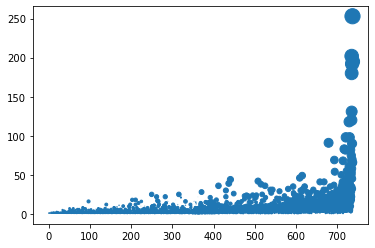

In [15]:
plt.scatter(y = df_rfmt['Frequency'], x= df_rfmt['Recency'], s= df_rfmt['Pred_purchases_lifetime'])
plt.show()

In [16]:
pivot_df = df_rfmt[['Frequency', 'Recency', 'Pred_purchases_lifetime']]
pivot_df = pd.pivot_table(pivot_df, values='Pred_purchases_lifetime', index='Recency', columns='Frequency')

<AxesSubplot:xlabel='Frequency', ylabel='Recency'>

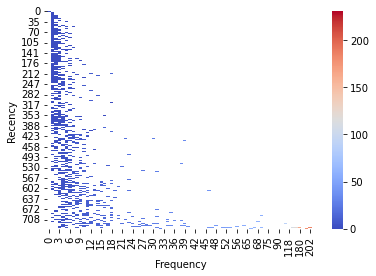

In [17]:
sns.heatmap(pivot_df, cmap='coolwarm')

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

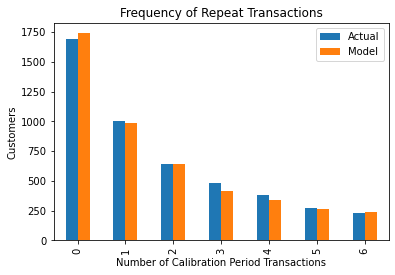

In [20]:
plot_period_transactions(bgf)

In [ ]:
# Checking how this model correctly predicts the frequency of repeat purchases within the different calibration periods 
# The model slight over-estimates the number of one-time customers however this model is still a good fit for the dataset.

In [21]:
# compute the probability that a customer is still alive
df_rfmt['alive_prob'] = bgf.conditional_probability_alive(df_rfmt['Frequency'], df_rfmt['Recency'], df_rfmt['Age'])
df_rfmt.head(10)

,Customer_ID,Frequency,Recency,Age,Avg_Amount,CLV,pred_purchases_180,Pred_purchases_lifetime,alive_prob
0,12346,6,196,725,53.265714,14.079332,0.059895,0.065219,0.039783
1,12347,7,402,404,615.191250,287.393856,2.863475,6.395094,0.986843
2,12348,4,363,438,331.680000,140.406568,1.581371,3.189099,0.959163
3,12349,2,571,589,1226.230000,65.606970,0.702552,2.228653,0.967096
4,12350,0,0,310,0.000000,17.426721,0.314474,0.000000,1.000000
5,12351,0,0,375,0.000000,21.460923,0.268389,0.000000,1.000000
6,12352,8,356,392,285.537778,221.050184,3.287503,6.501951,0.976993
7,12353,1,204,408,203.380000,18.453778,0.561831,0.636742,0.897574
8,12354,0,0,232,0.000000,18.327934,0.396139,0.000000,1.000000
9,12355,1,353,567,473.805000,60.184559,0.431382,0.845988,0.918624


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

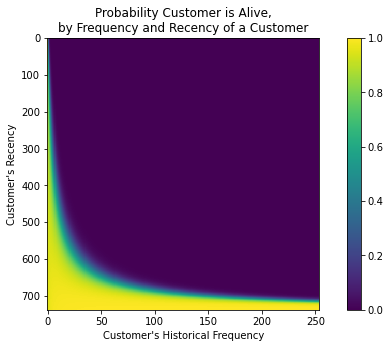

In [22]:
# visualize this
fig = plt.figure(figsize = (10,5))
plot_probability_alive_matrix(bgf)
# this illustrates that if the time between a customer's first and last purchases is high and the customer's frequency of
# purchases is also high, the customer is probably alive. Similarily, if a customer has low frequency but the time between
# the first and last purchases is also low, the customer is also probably alive. 

Using Holdout period

Re-fit the model using a calibration and holdout period.

In the first instance, the dataset contains data from 01/12/2009 to 09/12/2011 being 738 days. Use 60% of the data in the calibration set and 40% in the observation set. Hence calibration period will be 01/12/2009 - 17/02/2011, then observation period will be 18/02/2011 - 09/12/2011.

In [23]:
data = pd.read_csv('processed_data.csv')
data['InvoiceDate'] = pd.to_datetime(data.InvoiceDate)
data.head()

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Date,Time,Total_Price,Year,Day_of_week,days_since,seconds,time_of_day
0,1,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,2009-12-01,07:45,83.4,2009,Tuesday,738,27900,6 AM - 12 PM
1,2,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12-01,07:45,81.0,2009,Tuesday,738,27900,6 AM - 12 PM
2,3,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12-01,07:45,81.0,2009,Tuesday,738,27900,6 AM - 12 PM
3,4,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,2009-12-01,07:45,100.8,2009,Tuesday,738,27900,6 AM - 12 PM
4,5,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,2009-12-01,07:45,30.0,2009,Tuesday,738,27900,6 AM - 12 PM


In [24]:
cal_hold = calibration_and_holdout_data(data, 'Customer_ID', 'InvoiceDate', calibration_period_end='2011-02-17',
                                                                                observation_period_end='2011-12-09')

cal_hold.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer_ID,,,,,
12346,6.0,196.0,430.0,0.0,295.0
12347,2.0,87.0,109.0,5.0,295.0
12348,2.0,120.0,143.0,2.0,295.0
12349,1.0,182.0,294.0,1.0,295.0
12350,0.0,0.0,15.0,0.0,295.0


In [25]:
cal_hold.sort_values(by='frequency_holdout', ascending=False).head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer_ID,,,,,
14911,140.0,430.0,443.0,113.0,295.0
12748,105.0,410.0,440.0,96.0,295.0
17841,97.0,438.0,442.0,95.0,295.0
14606,110.0,438.0,441.0,70.0,295.0
15311,129.0,441.0,443.0,65.0,295.0


In [26]:
# re-fit the model using the calibration set and observe its effect on the observation set
bgf.fit(cal_hold['frequency_cal'], cal_hold['recency_cal'], cal_hold['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 4473 subjects, a: 0.15, alpha: 69.71, b: 8.39, r: 0.75>

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

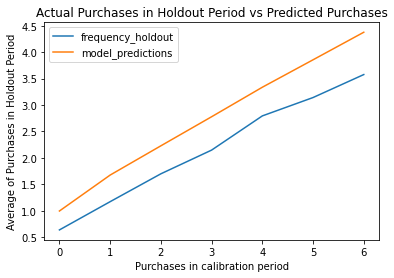

In [27]:
# visualize how the model fits within the observation period
plot_calibration_purchases_vs_holdout_purchases(bgf, cal_hold)

Using a longer holdout 

In [28]:
cal_hold_long = calibration_and_holdout_data(data, 'Customer_ID', 'InvoiceDate', calibration_period_end='2011-06-01',
                                                                                observation_period_end='2011-12-09')

cal_hold_long.sort_values(by='frequency_holdout', ascending=False).head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer_ID,,,,,
14911,168.0,541.0,547.0,85.0,191.0
12748,129.0,543.0,544.0,72.0,191.0
17841,124.0,545.0,546.0,68.0,191.0
15311,147.0,542.0,547.0,47.0,191.0
14606,136.0,542.0,545.0,44.0,191.0


In [29]:
# re-fit the model using the calibration set and observe its effect on the observation set
bgf.fit(cal_hold_long['frequency_cal'], cal_hold_long['recency_cal'], cal_hold_long['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 4930 subjects, a: 0.16, alpha: 66.05, b: 3.41, r: 0.68>

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

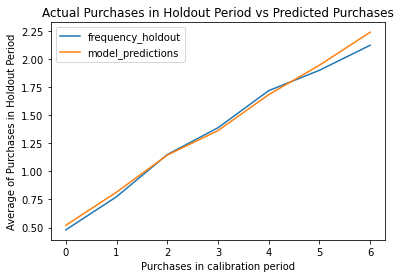

In [30]:
# visualize how the model fits within the observation period
plot_calibration_purchases_vs_holdout_purchases(bgf, cal_hold_long)

In [31]:
# getting predictions for a particular customer
df_rfmt.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,CLV,pred_purchases_180,Pred_purchases_lifetime,alive_prob
0,12346,6,196,725,53.265714,14.079332,0.059895,0.065219,0.039783
1,12347,7,402,404,615.191250,287.393856,2.863475,6.395094,0.986843
2,12348,4,363,438,331.680000,140.406568,1.581371,3.189099,0.959163
3,12349,2,571,589,1226.230000,65.606970,0.702552,2.228653,0.967096
4,12350,0,0,310,0.000000,17.426721,0.314474,0.000000,1.000000


In [32]:
df_rfmt.sort_values(by = 'Frequency').tail()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,CLV,pred_purchases_180,Pred_purchases_lifetime,alive_prob
2235,14606,180,735,736,164.814199,961.447014,40.195852,164.133064,0.999247
5430,17841,192,736,737,355.156736,3469.396759,42.814170,175.062385,0.999283
2933,15311,195,738,738,586.563367,8402.806939,43.434158,178.080050,0.999445
399,12748,202,735,735,261.851034,2946.205464,45.156118,184.387480,0.999464
2537,14911,253,737,738,1134.041220,7328.269179,56.306828,230.545178,0.999412


In [33]:
# for customer in index 2235
t = 365
individual = df_rfmt.iloc[2235]
bgf.predict(t, individual['Frequency'], individual['Recency'], individual['Age'])

79.60575406923621

In [34]:
data.head()

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Date,Time,Total_Price,Year,Day_of_week,days_since,seconds,time_of_day
0,1,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,2009-12-01,07:45,83.4,2009,Tuesday,738,27900,6 AM - 12 PM
1,2,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12-01,07:45,81.0,2009,Tuesday,738,27900,6 AM - 12 PM
2,3,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,2009-12-01,07:45,81.0,2009,Tuesday,738,27900,6 AM - 12 PM
3,4,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,2009-12-01,07:45,100.8,2009,Tuesday,738,27900,6 AM - 12 PM
4,5,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,2009-12-01,07:45,30.0,2009,Tuesday,738,27900,6 AM - 12 PM


In [35]:
cust_14606 = data.loc[data['Customer_ID'] == 14606]
cust_14606

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer_ID,Country,Date,Time,Total_Price,Year,Day_of_week,days_since,seconds,time_of_day
5222,5223,490024,84993B,75 BLACK PETIT FOUR CASES,5,2009-12-03 12:40:00,0.42,14606,United Kingdom,2009-12-03,12:40,2.10,2009,Thursday,736,45600,12 PM - 6 PM
5223,5224,490024,21944,KITTENS DESIGN FLANNEL,1,2009-12-03 12:40:00,0.85,14606,United Kingdom,2009-12-03,12:40,0.85,2009,Thursday,736,45600,12 PM - 6 PM
5224,5225,490024,20718,RED SPOTTY SHOPPER BAG,1,2009-12-03 12:40:00,1.25,14606,United Kingdom,2009-12-03,12:40,1.25,2009,Thursday,736,45600,12 PM - 6 PM
5225,5226,490024,20749,ASSORTED COLOUR MINI CASES,2,2009-12-03 12:40:00,7.95,14606,United Kingdom,2009-12-03,12:40,15.90,2009,Thursday,736,45600,12 PM - 6 PM
5226,5227,490024,21536,DAIRY MAID SMALL MILK JUG,1,2009-12-03 12:40:00,2.10,14606,United Kingdom,2009-12-03,12:40,2.10,2009,Thursday,736,45600,12 PM - 6 PM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776932,776933,581469,21485,RETROSPOT HEART HOT WATER BOTTLE,1,2011-12-08 19:28:00,4.95,14606,United Kingdom,2011-12-08,19:28,4.95,2011,Thursday,1,70080,6 PM - 0 AM
776933,776934,581469,22165,"DIAMANTE HEART SHAPED WALL MIRROR,",1,2011-12-08 19:28:00,3.95,14606,United Kingdom,2011-12-08,19:28,3.95,2011,Thursday,1,70080,6 PM - 0 AM
776934,776935,581469,21986,PACK OF 12 PINK POLKADOT TISSUES,1,2011-12-08 19:28:00,0.39,14606,United Kingdom,2011-12-08,19:28,0.39,2011,Thursday,1,70080,6 PM - 0 AM
776935,776936,581469,22087,PAPER BUNTING WHITE LACE,6,2011-12-08 19:28:00,2.95,14606,United Kingdom,2011-12-08,19:28,17.70,2011,Thursday,1,70080,6 PM - 0 AM


<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

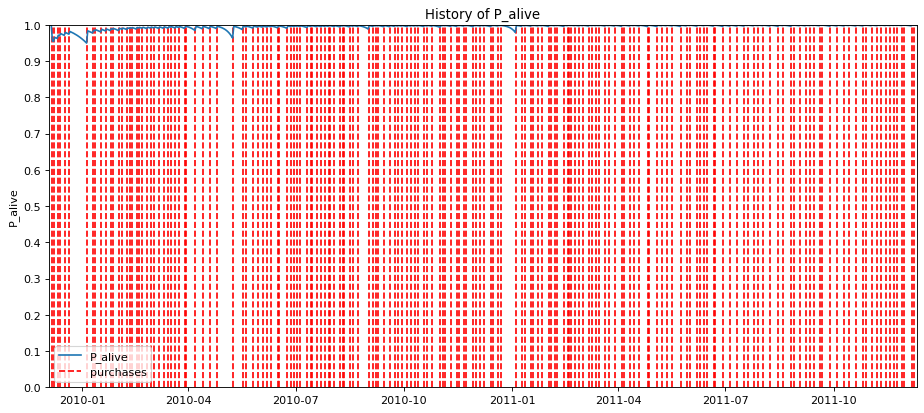

In [36]:
# plot the customer's probability of being alive
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

days_since_birth = 737
plot_history_alive(bgf, days_since_birth, cust_14606, 'InvoiceDate')

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

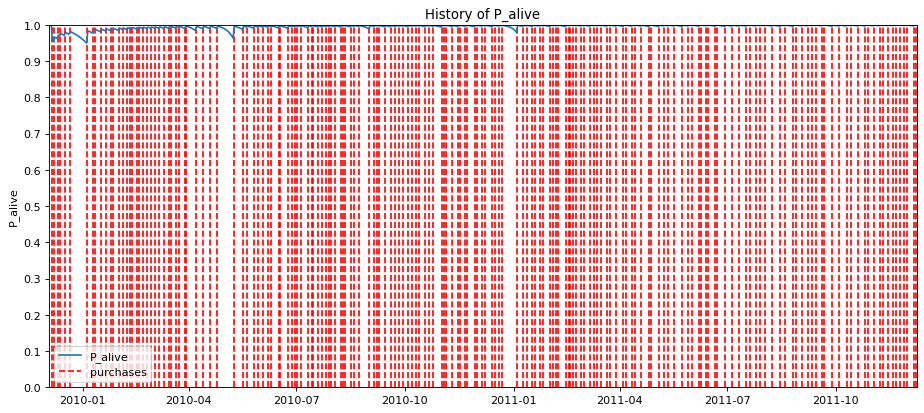

In [37]:
# decrease the tenure and observe the probability
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

days_since_birth = 182
plot_history_alive(bgf, days_since_birth, cust_14606, 'InvoiceDate')

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

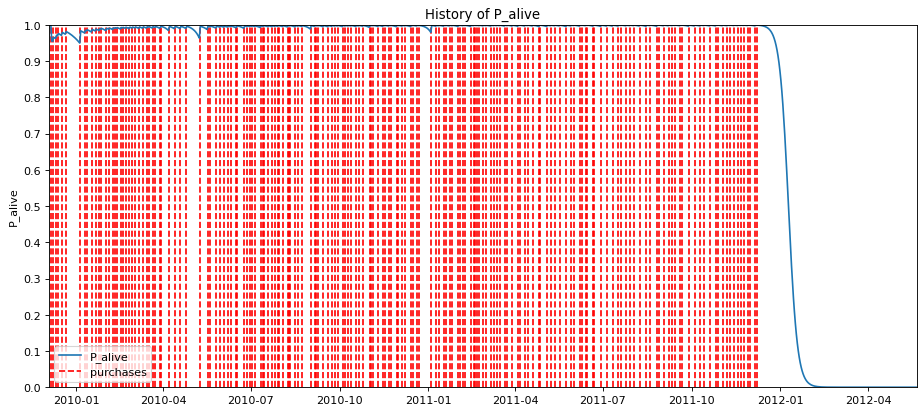

In [38]:
# increase the tenure and observe the probability
figure(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')

days_since_birth = 900
plot_history_alive(bgf, days_since_birth, cust_14606, 'InvoiceDate')

Gamma gamma model

In [39]:
# remove one-time customers: Frequency = 0
return_cust = df_rfmt.loc[(df_rfmt["Frequency"] > 0)]

In [40]:
# check the assumption of the gamma gamma model that there is no correlation between customers' frequency and their Average
# amount spent
return_cust[['Frequency', 'Avg_Amount']].corr()

,Frequency,Avg_Amount
Frequency,1.000000,0.134626
Avg_Amount,0.134626,1.000000


In [41]:
# the correlation coefficient is very weak hence the assumption is satisfied

In [42]:
# Fit a gamma gamma model using the training data
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(return_cust['Frequency'], return_cust['Avg_Amount'])
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.544003,0.241377,3.070905,4.017101
q,3.499912,0.105800,3.292544,3.707280
v,283.801766,26.554895,231.754171,335.849361


The estimated coefficient for p is 3.54, with a standard error of 0.24. This means that the average purchase amount of a customer increases by a factor of 3.54 for every doubling of their purchase frequency, on average, holding the other predictors constant. The 95% confidence interval for the true population coefficient for p is between 3.07 and 4.02.

The estimated coefficient for q is 3.50, with a standard error of 0.11. This means that the average purchase amount of a customer increases by a factor of 3.50 for every doubling of their average monetary value, on average, holding the other predictors constant. The 95% confidence interval for the true population coefficient for q is between 3.29 and 3.71.

The estimated coefficient for v is 283.80, with a standard error of 26.55. This means that the average purchase amount of a customer increases by $283.80 for every unit increase in their purchase frequency, on average, holding the other predictors constant. The 95% confidence interval for the true population coefficient for v is between 231.75 and 335.85.

The standard errors of the coefficients tell us about the amount of uncertainty in our estimates. Smaller standard errors indicate more precise estimates.

The confidence intervals tell us about the range of plausible values for the true population coefficients with a certain level of confidence. For example, the 95% confidence interval for p indicates that if we were to repeat the study many times, we would expect 95% of the confidence intervals to contain the true population coefficient for p.

In summary, the Gamma-Gamma model estimates how the purchase frequency and average monetary value of customers affect their purchase behavior. Based on the estimated coefficients and their confidence intervals, we can draw conclusions about the relative importance of these predictors in determining purchase behavior.

In [43]:
# next, predict the average amount each customer will spend per transaction
# first, we remove all customers with non-positive average spent amounts
avg_spent_above_zero = df_rfmt[df_rfmt['Avg_Amount'] > 0]

In [44]:
avg_spent_above_zero['pred_avg_sales'] = ggf.conditional_expected_average_profit(avg_spent_above_zero['Frequency'],
                                                                                 avg_spent_above_zero['Avg_Amount'])
avg_spent_above_zero.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,CLV,pred_purchases_180,Pred_purchases_lifetime,alive_prob,pred_avg_sales
0,12346,6,196,725,53.265714,14.079332,0.059895,0.065219,0.039783,89.986691
1,12347,7,402,404,615.191250,287.393856,2.863475,6.395094,0.986843,595.704983
2,12348,4,363,438,331.680000,140.406568,1.581371,3.189099,0.959163,342.271527
3,12349,2,571,589,1226.230000,65.606970,0.702552,2.228653,0.967096,1011.410395
6,12352,8,356,392,285.537778,221.050184,3.287503,6.501951,0.976993,295.001527


In [45]:
# Calculate avg_amount metrics
r2 = r2_score(avg_spent_above_zero['Avg_Amount'], avg_spent_above_zero['pred_avg_sales'])
adj_r2 = 1 - (1-r2)*(len(avg_spent_above_zero)-1)/(len(avg_spent_above_zero)-4)
rmse = mean_squared_error(avg_spent_above_zero['Avg_Amount'], avg_spent_above_zero['pred_avg_sales'], squared=False)
mse = mean_squared_error(avg_spent_above_zero['Avg_Amount'], avg_spent_above_zero['pred_avg_sales'])
mae = mean_absolute_error(avg_spent_above_zero['Avg_Amount'], avg_spent_above_zero['pred_avg_sales'])

In [46]:
# Print ave_amount metrics
print('R-squared:', r2)
print('Adjusted R-squared:', adj_r2)
print('Root Mean Squared Error:', rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

R-squared: 0.9044767630023952
Adjusted R-squared: 0.9044081728370068
Root Mean Squared Error: 170.88488799056248
Mean Squared Error: 29201.644943547086
Mean Absolute Error: 45.40656379489384


In [47]:
avg_spent_above_zero['pred_clv'] = ggf.customer_lifetime_value(bgf, avg_spent_above_zero['Frequency'], 
                                                               avg_spent_above_zero['Recency'], avg_spent_above_zero['Age'],
                                                              avg_spent_above_zero['Avg_Amount'], time = 1, freq = 'D',
                                                              discount_rate = 0.01)
avg_spent_above_zero.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,CLV,pred_purchases_180,Pred_purchases_lifetime,alive_prob,pred_avg_sales,pred_clv
0,12346,6,196,725,53.265714,14.079332,0.059895,0.065219,0.039783,89.986691,0.719239
1,12347,7,402,404,615.191250,287.393856,2.863475,6.395094,0.986843,595.704983,282.936001
2,12348,4,363,438,331.680000,140.406568,1.581371,3.189099,0.959163,342.271527,89.331948
3,12349,2,571,589,1226.230000,65.606970,0.702552,2.228653,0.967096,1011.410395,117.983502
6,12352,8,356,392,285.537778,221.050184,3.287503,6.501951,0.976993,295.001527,160.332053


In [48]:
# Calculate CLV metrics
r2 = r2_score(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])
adj_r2 = 1 - (1-r2)*(len(avg_spent_above_zero)-1)/(len(avg_spent_above_zero)-4)
rmse = mean_squared_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'], squared=False)
mse = mean_squared_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])
mae = mean_absolute_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])

In [49]:
# Print CLV metrics
print('R-squared:', r2)
print('Adjusted R-squared:', adj_r2)
print('Root Mean Squared Error:', rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

R-squared: 0.7553723108614163
Adjusted R-squared: 0.7551966567045432
Root Mean Squared Error: 329.3916596096178
Mean Squared Error: 108498.86542037834
Mean Absolute Error: 89.88858814508859


Extended BG/NBD/GG with DPR

In [50]:
df_rfmt_full.head()

,Unnamed: 0,Customer_ID,Recency,Frequency,Count_of_transactions,Total_Amount,DPR,Age,Avg_Amount,CSI,months_inactive,CLV
0,1,12346,196,6,7,372.86,26,725,53.265714,1,0.204123,14.079332
1,2,12347,402,7,8,4921.53,126,404,615.191250,6,0.060640,287.393856
2,3,12348,363,4,5,1658.40,24,438,331.680000,5,0.268889,140.406568
3,4,12349,571,2,3,3678.69,137,589,1226.230000,5,0.111314,65.606970
4,5,12350,0,0,1,294.40,16,310,0.000000,2,0.000000,17.426721


In [51]:
# select the relevant columns
df_rfmt2 = df_rfmt_full[['Customer_ID', 'Frequency', 'Recency', 'Age', 'Avg_Amount', 'DPR', 'CSI', 'CLV']]
df_rfmt2.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV
0,12346,6,196,725,53.265714,26,1,14.079332
1,12347,7,402,404,615.191250,126,6,287.393856
2,12348,4,363,438,331.680000,24,5,140.406568
3,12349,2,571,589,1226.230000,137,5,65.606970
4,12350,0,0,310,0.000000,16,2,17.426721


In [52]:
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(df_rfmt2['Frequency'], df_rfmt2['Recency'], df_rfmt2['Age'], df_rfmt2['DPR'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.825374,0.001707,0.822028,0.828721
alpha,32.780414,0.086631,32.610617,32.950211
a,0.052045,0.000984,0.050116,0.053975
b,7.250060,0.214406,6.829824,7.670295


In [60]:
# Estimate the number of purchases a customer will make in the next 180 days
t = 180
df_rfmt2['predicted_purchases_180'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      df_rfmt2['Frequency'], 
                                                                                      df_rfmt2['Recency'], 
                                                                                      df_rfmt2['Age'])

In [61]:
# add a column that calculates the predicted purchases throughout the lifetime
df_rfmt2['Pred_purchases_lifetime'] = df_rfmt2['predicted_purchases_180']/180 * df_rfmt2['Recency']
df_rfmt2.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,Pred_purchases_lifetime,predicted_purchases,predicted_purchases_180
0,12346,6,196,725,53.265714,26,1,14.079332,0.109434,0.100501,0.100501
1,12347,7,402,404,615.191250,126,6,287.393856,7.129449,3.192291,3.192291
2,12348,4,363,438,331.680000,24,5,140.406568,3.659916,1.814835,1.814835
3,12349,2,571,589,1226.230000,137,5,65.606970,2.569334,0.809948,0.809948
4,12350,0,0,310,0.000000,16,2,17.426721,0.000000,0.432022,0.432022


In [62]:
# Calculate Predicted purchases metrics
r2 = r2_score(df_rfmt2['Frequency'], df_rfmt2['Pred_purchases_lifetime'])
adj_r2 = 1 - (1-r2)*(len(df_rfmt2)-1)/(len(df_rfmt2)-4)
rmse = mean_squared_error(df_rfmt2['Frequency'], df_rfmt2['Pred_purchases_lifetime'], squared=False)
mse = mean_squared_error(df_rfmt2['Frequency'], df_rfmt2['Pred_purchases_lifetime'])
mae = mean_absolute_error(df_rfmt2['Frequency'], df_rfmt2['Pred_purchases_lifetime'])

In [63]:
print('R-squared:', r2)
print('Adjusted R-squared:', adj_r2)
print('Root Mean Squared Error:', rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

R-squared: 0.9738553190821315
Adjusted R-squared: 0.9738419572349843
Root Mean Squared Error: 1.6152530759516501
Mean Squared Error: 2.609042499371267
Mean Absolute Error: 0.6392040856697755


<AxesSubplot:title={'center':'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

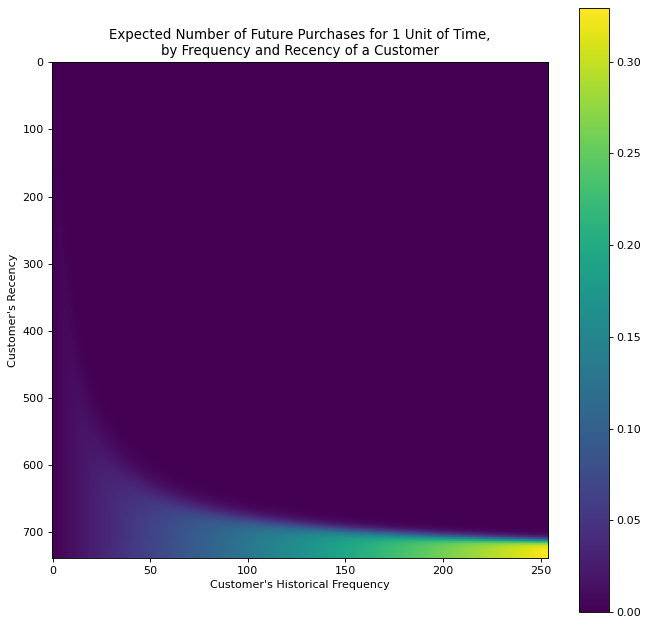

In [59]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plot_frequency_recency_matrix(bgf)

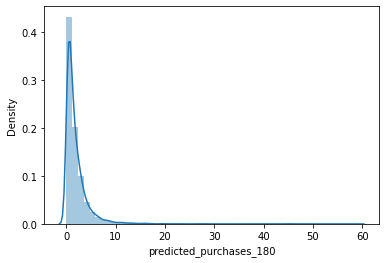

In [64]:
ax = sns.distplot(df_rfmt2['predicted_purchases_180'])

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

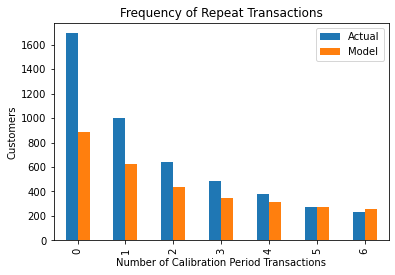

In [65]:
plot_period_transactions(bgf)

In [66]:
# compute the probability that a customer is still alive
df_rfmt2['alive_prob'] = bgf.conditional_probability_alive(df_rfmt2['Frequency'], df_rfmt2['Recency'], df_rfmt2['Age'])
df_rfmt2.head(10)

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,Pred_purchases_lifetime,predicted_purchases,predicted_purchases_180,alive_prob
0,12346,6,196,725,53.265714,26,1,14.079332,0.109434,0.100501,0.100501,0.062204
1,12347,7,402,404,615.191250,126,6,287.393856,7.129449,3.192291,3.192291,0.995945
2,12348,4,363,438,331.680000,24,5,140.406568,3.659916,1.814835,1.814835,0.988406
3,12349,2,571,589,1226.230000,137,5,65.606970,2.569334,0.809948,0.809948,0.993192
4,12350,0,0,310,0.000000,16,2,17.426721,0.000000,0.432022,0.432022,1.000000
5,12351,0,0,375,0.000000,21,3,21.460923,0.000000,0.363336,0.363336,1.000000
6,12352,8,356,392,285.537778,69,3,221.050184,7.290341,3.686128,3.686128,0.992083
7,12353,1,204,408,203.380000,23,4,18.453778,0.823540,0.726653,0.726653,0.978169
8,12354,0,0,232,0.000000,58,5,18.327934,0.000000,0.558792,0.558792,1.000000
9,12355,1,353,567,473.805000,35,4,60.184559,1.054639,0.537776,0.537776,0.984189


<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

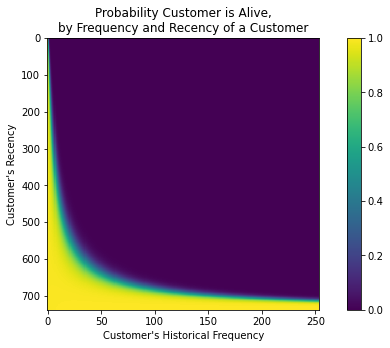

In [67]:
# visualize this
fig = plt.figure(figsize = (10,5))
plot_probability_alive_matrix(bgf)
# this illustrates that if the time between a customer's first and last purchases is high and the customer's frequency of
# purchases is also high, the customer is probably alive. Similarily, if a customer has low frequency but the time between
# the first and last purchases is also low, the customer is also probably alive. 

In [68]:
# gamma gamma model
# remove one-time customers: Frequency = 0
return_cust2 = df_rfmt2.loc[(df_rfmt2["Frequency"] > 0)]

In [69]:
# check the assumption of the gamma gamma model that there is no correlation between customers' frequency and their Average
# amount spent
return_cust2[['Frequency', 'Avg_Amount']].corr()

,Frequency,Avg_Amount
Frequency,1.000000,0.134626
Avg_Amount,0.134626,1.000000


In [70]:
# Fit a gamma gamma model using the training data
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(return_cust2['Frequency'], return_cust2['Avg_Amount'])
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.544003,0.241377,3.070905,4.017101
q,3.499912,0.105800,3.292544,3.707280
v,283.801766,26.554895,231.754171,335.849361


In [71]:
# next, predict the average amount each customer will spend per transaction
# first, we remove all customers with non-positive average spent amounts
avg_spent_above_zero = df_rfmt2[df_rfmt2['Avg_Amount'] > 0]

In [72]:
avg_spent_above_zero['pred_clv'] = ggf.customer_lifetime_value(bgf, avg_spent_above_zero['Frequency'], 
                                                               avg_spent_above_zero['Recency'], avg_spent_above_zero['Age'],
                                                              avg_spent_above_zero['Avg_Amount'], time = 1, freq = 'D',
                                                              discount_rate = 0.01)
avg_spent_above_zero.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,Pred_purchases_lifetime,predicted_purchases,predicted_purchases_180,alive_prob,pred_clv
0,12346,6,196,725,53.265714,26,1,14.079332,0.109434,0.100501,0.100501,0.062204,1.496647
1,12347,7,402,404,615.191250,126,6,287.393856,7.129449,3.192291,3.192291,0.995945,315.381630
2,12348,4,363,438,331.680000,24,5,140.406568,3.659916,1.814835,1.814835,0.988406,102.908582
3,12349,2,571,589,1226.230000,137,5,65.606970,2.569334,0.809948,0.809948,0.993192,135.511766
6,12352,8,356,392,285.537778,69,3,221.050184,7.290341,3.686128,3.686128,0.992083,180.399948


In [73]:
# Calculate CLV metrics
r2 = r2_score(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])
adj_r2 = 1 - (1-r2)*(len(avg_spent_above_zero)-1)/(len(avg_spent_above_zero)-4)
rmse = mean_squared_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'], squared=False)
mse = mean_squared_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])
mae = mean_absolute_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])

In [74]:
# Print CLV metrics
print('R-squared:', r2)
print('Adjusted R-squared:', adj_r2)
print('Root Mean Squared Error:', rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

R-squared: 0.7137371841187155
Adjusted R-squared: 0.7135316339876374
Root Mean Squared Error: 356.3216916120479
Mean Squared Error: 126965.14791327136
Mean Absolute Error: 98.67573733140588


Extended BG/NBD/GG with CSI

In [75]:
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(df_rfmt2['Frequency'], df_rfmt2['Recency'], df_rfmt2['Age'], df_rfmt2['CSI'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.774634,0.009543,0.755929,0.793339
alpha,70.574349,1.084568,68.448597,72.700101
a,0.096157,0.008582,0.079337,0.112977
b,3.325671,0.461666,2.420806,4.230535


In [76]:
# Estimate the number of purchases a customer will make in the next 180 days
t = 180
df_rfmt2['pred_purchases_180'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, df_rfmt2['Frequency'], 
                                                        df_rfmt2['Recency'], df_rfmt2['Age'])

In [77]:
# add a column that calculates the predicted purchases throughout the lifetime
df_rfmt2['Pred_purchases_lifetime'] = df_rfmt2['pred_purchases_180']/180 * df_rfmt2['Recency']
df_rfmt2.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,Pred_purchases_lifetime,predicted_purchases,predicted_purchases_180,alive_prob,pred_purchases_180
0,12346,6,196,725,53.265714,26,1,14.079332,0.082600,0.100501,0.100501,0.062204,0.075857
1,12347,7,402,404,615.191250,126,6,287.393856,6.426382,3.192291,3.192291,0.995945,2.877485
2,12348,4,363,438,331.680000,24,5,140.406568,3.260731,1.814835,1.814835,0.988406,1.616892
3,12349,2,571,589,1226.230000,137,5,65.606970,2.325729,0.809948,0.809948,0.993192,0.733154
4,12350,0,0,310,0.000000,16,2,17.426721,0.000000,0.432022,0.432022,1.000000,0.362459


In [78]:
# Calculate Predicted purchases metrics
r2 = r2_score(df_rfmt2['Frequency'], df_rfmt2['Pred_purchases_lifetime'])
adj_r2 = 1 - (1-r2)*(len(df_rfmt2)-1)/(len(df_rfmt2)-4)
rmse = mean_squared_error(df_rfmt2['Frequency'], df_rfmt2['Pred_purchases_lifetime'], squared=False)
mse = mean_squared_error(df_rfmt2['Frequency'], df_rfmt2['Pred_purchases_lifetime'])
mae = mean_absolute_error(df_rfmt2['Frequency'], df_rfmt2['Pred_purchases_lifetime'])

In [79]:
print('R-squared:', r2)
print('Adjusted R-squared:', adj_r2)
print('Root Mean Squared Error:', rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

R-squared: 0.961139229019821
Adjusted R-squared: 0.9611193683191497
Root Mean Squared Error: 1.9692670309366496
Mean Squared Error: 3.878012639134047
Mean Absolute Error: 0.8994367155758457


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

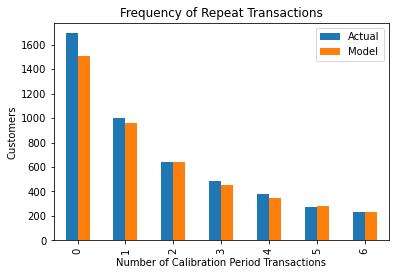

In [80]:
plot_period_transactions(bgf)

In [101]:
plot_dropout_rate_heterogeneity(bgf)

NameError: name 'plot_dropout_rate_heterogeneity' is not defined

In [81]:
# gamma gamma model
# remove one-time customers: Frequency = 0
return_cust2 = df_rfmt2.loc[(df_rfmt2["Frequency"] > 0)]

In [82]:
# check the assumption of the gamma gamma model that there is no correlation between customers' frequency and their Average
# amount spent
return_cust2[['Frequency', 'Avg_Amount']].corr()

,Frequency,Avg_Amount
Frequency,1.000000,0.134626
Avg_Amount,0.134626,1.000000


In [83]:
# Fit a gamma gamma model using the training data
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(return_cust2['Frequency'], return_cust2['Avg_Amount'])
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.544003,0.241377,3.070905,4.017101
q,3.499912,0.105800,3.292544,3.707280
v,283.801766,26.554895,231.754171,335.849361


In [84]:
# next, predict the average amount each customer will spend per transaction
# first, we remove all customers with non-positive average spent amounts
avg_spent_above_zero = df_rfmt2[df_rfmt2['Avg_Amount'] > 0]

In [85]:
avg_spent_above_zero['pred_clv'] = ggf.customer_lifetime_value(bgf, avg_spent_above_zero['Frequency'], 
                                                               avg_spent_above_zero['Recency'], avg_spent_above_zero['Age'],
                                                              avg_spent_above_zero['Avg_Amount'], time = 1, freq = 'D',
                                                              discount_rate = 0.01)
avg_spent_above_zero.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,Pred_purchases_lifetime,predicted_purchases,predicted_purchases_180,alive_prob,pred_purchases_180,pred_clv
0,12346,6,196,725,53.265714,26,1,14.079332,0.082600,0.100501,0.100501,0.062204,0.075857,1.134293
1,12347,7,402,404,615.191250,126,6,287.393856,6.426382,3.192291,3.192291,0.995945,2.877485,286.096461
2,12348,4,363,438,331.680000,24,5,140.406568,3.260731,1.814835,1.814835,0.988406,1.616892,92.235258
3,12349,2,571,589,1226.230000,137,5,65.606970,2.325729,0.809948,0.809948,0.993192,0.733154,123.229387
6,12352,8,356,392,285.537778,69,3,221.050184,6.532406,3.686128,3.686128,0.992083,3.302902,162.696310


In [86]:
# Calculate CLV metrics
r2 = r2_score(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])
adj_r2 = 1 - (1-r2)*(len(avg_spent_above_zero)-1)/(len(avg_spent_above_zero)-4)
rmse = mean_squared_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'], squared=False)
mse = mean_squared_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])
mae = mean_absolute_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])

In [87]:
# Print CLV metrics
print('R-squared:', r2)
print('Adjusted R-squared:', adj_r2)
print('Root Mean Squared Error:', rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

R-squared: 0.7574553329805404
Adjusted R-squared: 0.7572811745312684
Root Mean Squared Error: 327.9862647853788
Mean Squared Error: 107574.9898878646
Mean Absolute Error: 89.57720620480477


BG/NBD/GG model with DPR and CSI

Using PCA to combine DPR and CSI to get a single component

In [5]:
from sklearn.decomposition import PCA

In [108]:
df_rfmt_full.head()

,Unnamed: 0,Customer_ID,Recency,Frequency,Count_of_transactions,Total_Amount,DPR,Age,Avg_Amount,CSI,months_inactive,CLV
0,1,12346,196,6,7,372.86,26,725,53.265714,1,0.204123,14.079332
1,2,12347,402,7,8,4921.53,126,404,615.191250,6,0.060640,287.393856
2,3,12348,363,4,5,1658.40,24,438,331.680000,5,0.268889,140.406568
3,4,12349,571,2,3,3678.69,137,589,1226.230000,5,0.111314,65.606970
4,5,12350,0,0,1,294.40,16,310,0.000000,2,0.000000,17.426721


In [109]:
# extract only the relevant colums and seperate the identifier column from the 2 features
pca_data = df_rfmt_full[['DPR', 'CSI']]
pca_data.head()

,DPR,CSI
0,26,1
1,126,6
2,24,5
3,137,5
4,16,2


In [110]:
df_rfmt4 = df_rfmt_full[['Customer_ID', 'Frequency', 'Recency', 'Age', 'Avg_Amount', 'DPR', 'CSI', 'CLV']]
df_rfmt4.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV
0,12346,6,196,725,53.265714,26,1,14.079332
1,12347,7,402,404,615.191250,126,6,287.393856
2,12348,4,363,438,331.680000,24,5,140.406568
3,12349,2,571,589,1226.230000,137,5,65.606970
4,12350,0,0,310,0.000000,16,2,17.426721


In [111]:
# standardize the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
pca_data = scaler.fit_transform(pca_data)

In [112]:
# fit the pca model
pca = PCA(n_components=1)
pc = pca.fit_transform(pca_data)

In [113]:
pc

array([[-1.76529174],
       [ 1.68501078],
       [ 0.49722486],
       ...,
       [-0.14427707],
       [ 0.75822721],
       [ 1.07992779]])

In [114]:
# add the components to a dataframe and combine with Customer_ID
pc_df = pd.DataFrame(data=pc, columns=['PC1'])
df_rfmt4 = pd.concat([df_rfmt4, pc_df], axis=1)

In [115]:
df_rfmt4.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,PC1
0,12346,6,196,725,53.265714,26,1,14.079332,-1.765292
1,12347,7,402,404,615.191250,126,6,287.393856,1.685011
2,12348,4,363,438,331.680000,24,5,140.406568,0.497225
3,12349,2,571,589,1226.230000,137,5,65.606970,1.183115
4,12350,0,0,310,0.000000,16,2,17.426721,-1.257326


In [116]:
df_rfmt4 = df_rfmt4.dropna()

In [117]:
df_rfmt4.describe()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,PC1
count,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000,5757.000000
mean,15318.368942,4.717388,278.907938,475.575473,294.438119,83.620809,3.529616,140.153492,0.022958
std,1715.992383,10.069505,258.579085,223.256319,504.739944,117.104306,1.237460,573.238788,1.128953
min,12346.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,-125.101976,-1.917037
25%,13834.000000,0.000000,0.000000,316.000000,0.000000,20.000000,3.000000,14.895303,-0.725081
50%,15321.000000,2.000000,231.000000,534.000000,227.636667,46.000000,4.000000,38.822903,-0.035020
75%,16802.000000,5.000000,518.000000,668.000000,381.665000,105.000000,5.000000,108.021326,0.661110
max,18287.000000,253.000000,738.000000,738.000000,22267.150000,2550.000000,6.000000,19492.287829,15.829596


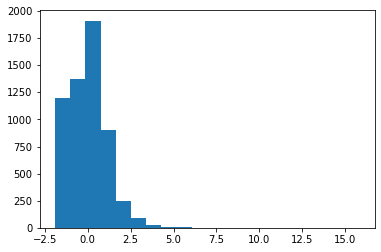

In [118]:
from scipy.stats import boxcox
import numpy as np

# Step 1: Check the distribution of PC1
plt.hist(df_rfmt4['PC1'], bins=20)
plt.show()

In [120]:
df_rfmt4['PC2'] = abs(df_rfmt4['PC1'])

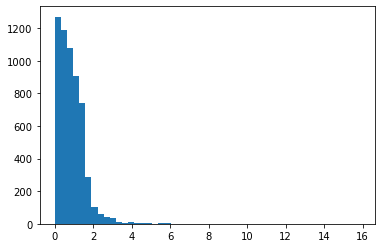

In [121]:
# Step 1: Check the distribution of PC1
plt.hist(df_rfmt4['PC2'], bins=50)
plt.show()

In [122]:
bgf = BetaGeoFitter(penalizer_coef=0)
bgf.fit(df_rfmt4['Frequency'], df_rfmt4['Recency'], df_rfmt4['Age'], df_rfmt4['PC2'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.451872,0.010489,0.431314,0.472429
alpha,26.875875,0.872666,25.165449,28.586301
a,0.042528,0.005634,0.031486,0.053569
b,1.031721,0.216520,0.607341,1.456101


In [123]:
# Estimate the number of purchases a customer will make in the next 180 days
t = 180
df_rfmt4['pred_purchases_180'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                                                      df_rfmt4['Frequency'], 
                                                                                      df_rfmt4['Recency'], 
                                                                                      df_rfmt4['Age'])

In [124]:
# add a column that calculates the predicted purchases throughout the lifetime
df_rfmt4['Pred_purchases_lifetime'] = df_rfmt4['pred_purchases_180']/180 * df_rfmt4['Recency']
df_rfmt4.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,PC1,PC2,pred_purchases_180,Pred_purchases_lifetime
0,12346,6,196,725,53.265714,26,1,14.079332,-1.765292,1.765292,0.080877,0.088066
1,12347,7,402,404,615.191250,126,6,287.393856,1.685011,1.685011,3.068494,6.852970
2,12348,4,363,438,331.680000,24,5,140.406568,0.497225,0.497225,1.671736,3.371335
3,12349,2,571,589,1226.230000,137,5,65.606970,1.183115,1.183115,0.696403,2.209145
4,12350,0,0,310,0.000000,16,2,17.426721,-1.257326,1.257326,0.238366,0.000000


In [125]:
# Calculate Predicted purchases metrics
r2 = r2_score(df_rfmt4['Frequency'], df_rfmt4['Pred_purchases_lifetime'])
adj_r2 = 1 - (1-r2)*(len(df_rfmt4)-1)/(len(df_rfmt4)-4)
rmse = mean_squared_error(df_rfmt4['Frequency'], df_rfmt4['Pred_purchases_lifetime'], squared=False)
mse = mean_squared_error(df_rfmt4['Frequency'], df_rfmt4['Pred_purchases_lifetime'])
mae = mean_absolute_error(df_rfmt4['Frequency'], df_rfmt4['Pred_purchases_lifetime'])

In [126]:
print('R-squared:', r2)
print('Adjusted R-squared:', adj_r2)
print('Root Mean Squared Error:', rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

R-squared: 0.9723056556648488
Adjusted R-squared: 0.9722912139765114
Root Mean Squared Error: 1.6755829454559743
Mean Squared Error: 2.8075782071029187
Mean Absolute Error: 0.7161846743666634


<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

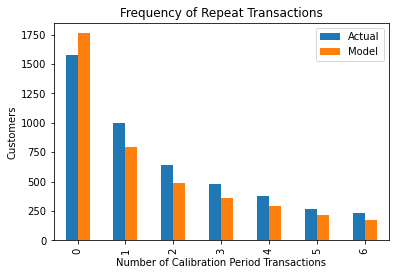

In [127]:
plot_period_transactions(bgf)

In [128]:
# gamma gamma model
# remove one-time customers: Frequency = 0
return_cust2 = df_rfmt4.loc[(df_rfmt4["Frequency"] > 0)]

In [129]:
# check the assumption of the gamma gamma model that there is no correlation between customers' frequency and their Average
# amount spent
return_cust2[['Frequency', 'Avg_Amount']].corr()

,Frequency,Avg_Amount
Frequency,1.000000,0.134626
Avg_Amount,0.134626,1.000000


In [130]:
# Fit a gamma gamma model using the training data
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(return_cust2['Frequency'], return_cust2['Avg_Amount'])
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.544003,0.241377,3.070905,4.017101
q,3.499912,0.105800,3.292544,3.707280
v,283.801766,26.554895,231.754171,335.849361


In [131]:
# next, predict the average amount each customer will spend per transaction
# first, we remove all customers with non-positive average spent amounts
avg_spent_above_zero = df_rfmt4[df_rfmt4['Avg_Amount'] > 0]

In [132]:
avg_spent_above_zero['pred_clv'] = ggf.customer_lifetime_value(bgf, avg_spent_above_zero['Frequency'], 
                                                               avg_spent_above_zero['Recency'], avg_spent_above_zero['Age'],
                                                              avg_spent_above_zero['Avg_Amount'], time = 1, freq = 'D',
                                                              discount_rate = 0.01)
avg_spent_above_zero.head()

,Customer_ID,Frequency,Recency,Age,Avg_Amount,DPR,CSI,CLV,PC1,PC2,pred_purchases_180,Pred_purchases_lifetime,pred_clv
0,12346,6,196,725,53.265714,26,1,14.079332,-1.765292,1.765292,0.080877,0.088066,1.205878
1,12347,7,402,404,615.191250,126,6,287.393856,1.685011,1.685011,3.068494,6.852970,303.652127
2,12348,4,363,438,331.680000,24,5,140.406568,0.497225,0.497225,1.671736,3.371335,95.025038
3,12349,2,571,589,1226.230000,137,5,65.606970,1.183115,1.183115,0.696403,2.209145,116.833555
6,12352,8,356,392,285.537778,69,3,221.050184,-0.366961,0.366961,3.561473,7.043803,174.554978


In [133]:
# Calculate CLV metrics
r2 = r2_score(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])
adj_r2 = 1 - (1-r2)*(len(avg_spent_above_zero)-1)/(len(avg_spent_above_zero)-4)
rmse = mean_squared_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'], squared=False)
mse = mean_squared_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])
mae = mean_absolute_error(avg_spent_above_zero['CLV'], avg_spent_above_zero['pred_clv'])

In [134]:
# Print CLV metrics
print('R-squared:', r2)
print('Adjusted R-squared:', adj_r2)
print('Root Mean Squared Error:', rmse)
print('Mean Squared Error:', mse)
print('Mean Absolute Error:', mae)

R-squared: 0.7126666368000116
Adjusted R-squared: 0.712460317965737
Root Mean Squared Error: 356.9873443558377
Mean Squared Error: 127439.96403023346
Mean Absolute Error: 95.79146763447041
